In [2]:
!pip install segmentation_models_pytorch==0.3.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=1a7d2fa4160f8c9bf124608acaab6e978365ae84d7397c6374be6a34f8b61f2c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=59397121c195e95b612b2f3609b82c0ca253d84b224c825207a316dcb9d69bbc
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

In [3]:
!pip install pytorch-msssim

In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from segmentation_models_pytorch import Unet
from google.colab import drive
from torchvision.models import vgg16
from pytorch_msssim import SSIM
# Mount Drive
drive.mount('/content/drive/', force_remount=True)
root_dir = '/content/drive/MyDrive/DeepNeuralNetworks/'

# Directory paths
algonauts_dir = 'algonauts_2023_tutorial_data'
reduced_images_dir = 'reduced_images_algonauts'
# Loading reduced images
reduced_images = np.load(os.path.join(root_dir, reduced_images_dir, 'subj01', 'images.npy'))

Mounted at /content/drive/


In [5]:
# Helper functions to load fMRI data and images
def load_fmri_of_subject(subj, hemisphere, directory=root_dir):
    subj = format(subj, '02')
    data_dir = os.path.join(directory, algonauts_dir, f'subj{subj}')
    fmri_dir = os.path.join(data_dir, 'training_split', 'training_fmri')
    if hemisphere == 'left':
        brain_activity = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
    else:
        brain_activity = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))
    return brain_activity

# Loads the data associated to a specific part of the brain (Some will be empty, it varies by subject)
def load_fmri_region_of_interest( subj, roi, hemisphere, directory = root_dir):
  subj = format(subj, '02')
  data_dir = os.path.join(directory, algonauts_dir, 'subj' + subj) # subj01
    # Define the ROI class based on the selected ROI
  if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
      roi_class = 'prf-visualrois'
  elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
      roi_class = 'floc-bodies'
  elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
      roi_class = 'floc-faces'
  elif roi in ["OPA", "PPA", "RSC"]:
      roi_class = 'floc-places'
  elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
      roi_class = 'floc-words'
  elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
      roi_class = 'streams'

  # Loading the roi masks (To locate the activations of a given region)
  roi_class_dir = os.path.join(data_dir, 'roi_masks',
      hemisphere[0]+'h.'+roi_class+'_challenge_space.npy')
  roi_map_dir = os.path.join(data_dir, 'roi_masks',
      'mapping_'+roi_class+'.npy')
  roi_class_idx = np.load(roi_class_dir)
  roi_map = np.load(roi_map_dir, allow_pickle=True).item()
  roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
  challenge_roi = np.asarray(roi_class_idx == roi_mapping, dtype=int)

  # Selection the appropriate data
  fmri_dir = os.path.join(data_dir, 'training_split', 'training_fmri') # Location the brain activation
  # Here we load the data
  if hemisphere == 'left':
    brain_activity = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
  else:
    brain_activity = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

  fmri_roi_data = brain_activity[:,np.where(challenge_roi)[0]]

  return fmri_roi_data

def load_reduced_image_subject(subj, img):
    image = reduced_images[img]
    return Image.fromarray(image)

# Visualization helper
def showImage(ax, image, title=''):
    image = image.cpu() # Move to CPU
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to 0-1
    ax.imshow(image.permute(1, 2, 0).squeeze(), cmap="gray")  # Display as grayscale
    ax.set_title(title)

# Custom dataset
class BrainDataSet(Dataset):
    def __init__(self, subject, hemisphere, transform=None, roi=None):
        self.subject = subject
        self.hemisphere = hemisphere
        if roi:
            # Load ROI-specific fMRI data
            self.fmri_data = load_fmri_region_of_interest(subject, roi, hemisphere)
        else:
            # Load full brain activity data
            self.fmri_data = load_fmri_of_subject(subject, hemisphere)

        self.data_len, self.num_samples = self.fmri_data.shape
        self.transform = transform
        #self.train = train

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        x = self.fmri_data[idx, :]
        img = load_reduced_image_subject(subj=self.subject, img=idx)
        if self.transform:
            img = self.transform(img)
        return img, torch.from_numpy(x)

# Data transforms
resize_normalize = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Dataset and DataLoader
subject = 1
hemisphere = 'left'
roi = 'V1d'
myDataset = BrainDataSet(subject, hemisphere, resize_normalize, roi=roi)
# DataLoader handles batching, shuffling, and parallel processing to make training efficient.
train_loader = DataLoader(dataset=myDataset, batch_size=32, shuffle=True, worker_init_fn=np.random.seed(42))
input_features = myDataset.num_samples
print("input_features:", input_features)
#  Automatically selects the computation device based on availability:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_features: 828


In [6]:
# U-Net model definition
# Add a fully connected (FC) network to process brain activity data and convert it into spatial feature maps compatible with the image feature maps.
class UNetWithBrainActivity(Unet):
    def __init__(self, input_features, *args, **kwargs):
        super(UNetWithBrainActivity, self).__init__(*args, **kwargs)
        self.brain_activity_fc = nn.Sequential(
            nn.Linear(input_features, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 32 * 32)  # Match spatial size
        )

    def forward(self, x, brain_activity):
        #print("Input image shape:", x.shape) # [32, 3, 32, 32]
        #print("Brain activity input shape:", brain_activity.shape) # [32, 19004]

        # Process brain activity
        brain_activity_features = self.brain_activity_fc(brain_activity)
       # print("Brain activity features after FC layers:", brain_activity_features.shape) # [32, 1024]

        brain_activity_features = brain_activity_features.view(
            -1, 1, 32, 32
        )  # Reshape from [batch_size,32×32] to [batch_size,1,32,32].
        #print("Reshaped brain activity features:", brain_activity_features.shape)

        brain_activity_features = brain_activity_features.expand(-1, 3, -1, -1)  # Match RGB channels [32, 3, 32, 32]
        #print("Brain activity features expanded to RGB channels:", brain_activity_features.shape)

        # Concatenate with image features
        x = torch.cat([x, brain_activity_features], dim=1)  # Concatenate along the channel dimension
       # print("Shape after concatenating image and brain activity features:", x.shape)
        # Decoder Block
        output = super(UNetWithBrainActivity, self).forward(x)
        #print("Output shape after UNet decoder:", output.shape)
        return output

In [7]:
# Encoder Block
model = UNetWithBrainActivity(
    input_features=input_features,
    encoder_name="resnet34", # the backbone for the encoder and uses residual connections (shortcuts) to make training deeper networks easier and avoid vanishing gradients.
    encoder_weights="imagenet", #  loads pre-trained weights from ImageNet, It speeds up training by starting with a model already capable of extracting general features from images.
    in_channels=6,
    classes=3
).to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 131MB/s]


In [8]:
# VGG for perceptual loss ( used for image-related tasks because of its simple and effective design (13 convolutional layers and 3 fully connected layers))
vgg = vgg16(pretrained=True).features[:16].eval().to(device)
for param in vgg.parameters():
    param.requires_grad = False # Prevents the model's weights from being updated during backpropagation.

# compares their high-level feature representations extracted by a pre-trained model
def perceptual_loss(output, target):
    output_features = vgg(output)
    with torch.no_grad(): # Prevents gradient calculations for target_features since we don’t need to backpropagate through the pre-trained VGG for target images.
        target_features = vgg(target)
    return nn.MSELoss()(output_features, target_features)


# Loss Function
mse_loss = nn.MSELoss()
# 1−SSIM is used because SSIM returns a similarity score where 1 indicates identical images. Subtracting it from 1 converts it into a loss term.
ssim_loss = SSIM(data_range=1.0, size_average=True, channel=3) # If True, the SSIM values computed for different patches or batches will be averaged to return a single scalar loss.

def combined_loss(output, target):
    mse = mse_loss(output, target)
    perceptual = perceptual_loss(output, target)
    ssim = ssim_loss(output, target)
    return 0.4 * mse + 0.4 * perceptual + 0.2 * (1 - ssim)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 79.5MB/s]


In [9]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

# Training function
def train_unet_with_brain_activity():
    epochs = 100
    loss_history = []

    for epoch in range(epochs):
        #print(f"\nStarting Epoch {epoch+1}/{epochs}")
        model.train()
        epoch_losses = []
        for x, brain_activity in train_loader:
            # Log input shapes
            #print(f" - Input image shape: {x.shape}")
            #print(f" - Brain activity shape: {brain_activity.shape}")

            x, brain_activity = x.to(device), brain_activity.to(device)

            optimizer.zero_grad()
            # Pass both image and brain activity to the model
            reconstructed = model(x, brain_activity)
            # Log output shape
            #print(f" - Reconstructed output shape: {reconstructed.shape}") # [32, 3, 32, 32]

            # Calculate combined loss
            total_loss = combined_loss(reconstructed, x)
            # Log loss
            #print(f" - Combined Loss: {total_loss.item():.4f}")

            # Backpropagation ( Computes gradients of the loss with respect to model parameters.)
            total_loss.backward()
            # Updates model parameters using the computed gradients.
            optimizer.step()
            epoch_losses.append(total_loss.item())

        # Log epoch loss
        mean_loss = sum(epoch_losses) / len(epoch_losses)
        loss_history.append(mean_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {mean_loss:.4f}")

        # Step the scheduler
        scheduler.step(mean_loss)
    return model, loss_history


# Train the model
trained_model, losses = train_unet_with_brain_activity()


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Loss: 5.0538
Epoch [2/100], Loss: 1.9101
Epoch [3/100], Loss: 1.3126
Epoch [4/100], Loss: 1.0520
Epoch [5/100], Loss: 1.0571
Epoch [6/100], Loss: 0.8282
Epoch [7/100], Loss: 0.7769
Epoch [8/100], Loss: 0.7309
Epoch [9/100], Loss: 0.6571
Epoch [10/100], Loss: 0.6245
Epoch [11/100], Loss: 0.5756
Epoch [12/100], Loss: 0.7559
Epoch [13/100], Loss: 0.5913
Epoch [14/100], Loss: 0.5561
Epoch [15/100], Loss: 0.5332
Epoch [16/100], Loss: 0.4957
Epoch [17/100], Loss: 0.4911
Epoch [18/100], Loss: 0.4990
Epoch [19/100], Loss: 0.4972
Epoch [20/100], Loss: 0.4752
Epoch [21/100], Loss: 0.4628
Epoch [22/100], Loss: 0.5271
Epoch [23/100], Loss: 0.5336
Epoch [24/100], Loss: 0.4737
Epoch [25/100], Loss: 0.4295
Epoch [26/100], Loss: 0.4253
Epoch [27/100], Loss: 0.4049
Epoch [28/100], Loss: 0.4477
Epoch [29/100], Loss: 0.4340
Epoch [30/100], Loss: 0.4109
Epoch [31/100], Loss: 0.4316
Epoch [32/100], Loss: 0.3847
Epoch [33/100], Loss: 0.3978
Epoch [34/100], Loss: 0.4136
Epoch [35/100], Loss: 0

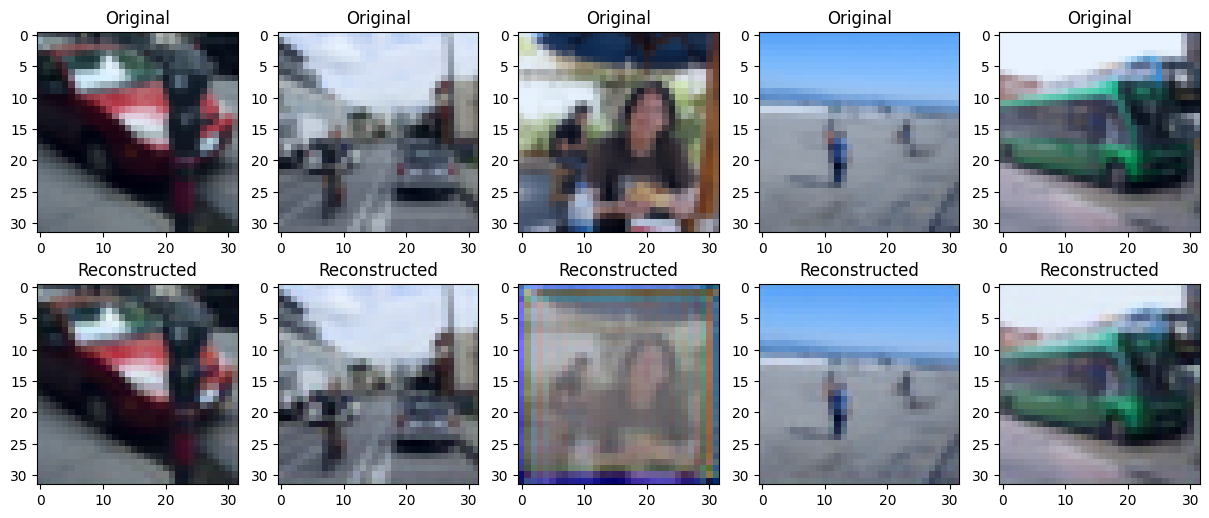

In [40]:
# Evaluation function
def evaluate_on_test_data(model, test_loader):
    model.eval()
    with torch.no_grad():
        for x, brain_activity in test_loader:
            x, brain_activity = x.to(device), brain_activity.to(device)
            reconstructed = model(x, brain_activity)

            # Show alternate images
            fig, axes = plt.subplots(2, 5, figsize=(15, 6))
            for i, idx in enumerate(range(0, len(x), 2)):  # Alternate indices (0, 2, 4, ...)
                if i >= 5:  # Limit to 5 images
                    break
                showImage(axes[0, i], x[idx], title="Original")
                showImage(axes[1, i], reconstructed[idx], title="Reconstructed")

            plt.show()
            return  # Show only one batch at a time

# Evaluate the model
evaluate_on_test_data(trained_model, train_loader)

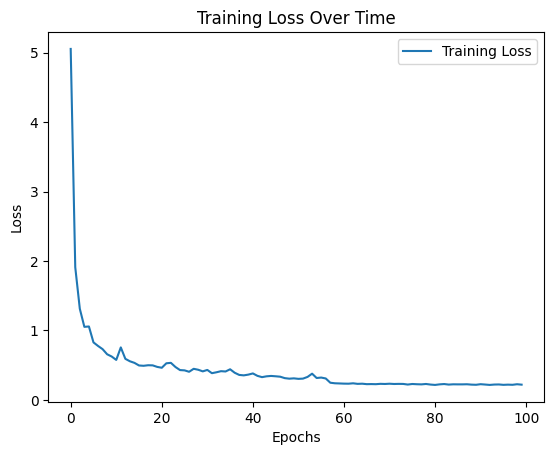

In [41]:
# Plot training loss
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()